# Анализ данных мониторинга

В данной работе были проанализированны данные мониторинга, полученные от компьютеров, рассположенных в различных участках сети. Был получен ответ на вопрос о статистической различимости пингов, открытия карточек заявлений и списков заявлений между компьютерами в исследуемой сети и опорным компьютером вне её.

Непосредственно мониторинг производился круглосуточно с 27.03.24 по 04.04.24.
При этом станции мониторинга были размещены в пяти сегментах различных СПД:
1.	Две станции в сегменте СПД ФБУЗ/РПН (Графский), который имел оконечную связность с КМС посредством прокси–сервера, на котором были включены проксирование и фильтрация трафика.
2.	Одна станция в сегменте СПД ФБУЗ/РПН (Графский), который имел оконечную связность с КМС напрямую (без прокси–сервера).
3.	Одна станция в сегменте СПД ФБУЗ/РПН (Бочкова), который имел оконечную связность с КМС напрямую (без прокси–сервера).
4.	Одна станция в сегменте СПД ФБУЗ/РПН (Графский), который имел оконечную связность с КМС напрямую (без прокси–сервера).


## Данные

Исследуемые данные были получены с интересующих нас компьютеров и записаны в соответсвующие `.csv` файлы.

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import datetime
import time

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving all_1.csv to all_1.csv
Saving all_2.csv to all_2.csv
Saving all_3.csv to all_3.csv
Saving all_4.csv to all_4.csv
Saving all_ld.csv to all_ld.csv
User uploaded file "all_1.csv" with length 8195069 bytes
User uploaded file "all_2.csv" with length 6240587 bytes
User uploaded file "all_3.csv" with length 4021157 bytes
User uploaded file "all_4.csv" with length 5929904 bytes
User uploaded file "all_ld.csv" with length 7375801 bytes


Загрузим эти данные.

In [ ]:
df_1 = pd.read_csv("all_1.csv", sep='|')
df_2 = pd.read_csv("all_2.csv", sep='|')
df_3 = pd.read_csv("all_3.csv", sep='|')
df_4 = pd.read_csv("all_4.csv", sep='|')
df_ld = pd.read_csv("all_ld.csv", sep='|')

Сведём данные о времени к единому удобному формату.

In [ ]:
df_1['clock'] = pd.to_datetime(df_1['clock'], format='%Y-%m-%d %H:%M:%S')
df_2['clock'] = pd.to_datetime(df_2['clock'], format='%Y-%m-%d %H:%M:%S')
df_3['clock'] = pd.to_datetime(df_3['clock'], format='%Y-%m-%d %H:%M:%S')
df_4['clock'] = pd.to_datetime(df_4['clock'], format='%Y-%m-%d %H:%M:%S')
df_ld['clock'] = pd.to_datetime(df_ld['clock'], format='%Y-%m-%d %H:%M:%S')

Уберём из исследуемых данных информацию о мониторинге до даты установки компьютеров в исследуемую сеть.

Поскольку нас интересует исследование рабочий сети в будние дни, также уберём информацию о выходнных днях из рассмотрения.

In [ ]:
df_1 = df_1[(df_1['clock'].dt.date >= datetime.date(2024, 3, 28)) & (df_1['clock'].dt.weekday < 5)].reset_index(drop=True)
df_2 = df_2[(df_2['clock'].dt.date >= datetime.date(2024, 3, 28)) & (df_2['clock'].dt.weekday < 5)].reset_index(drop=True)
df_3 = df_3[(df_3['clock'].dt.date >= datetime.date(2024, 3, 28)) & (df_3['clock'].dt.weekday < 5)].reset_index(drop=True)
df_4 = df_4[(df_4['clock'].dt.date >= datetime.date(2024, 3, 28)) & (df_4['clock'].dt.weekday < 5)].reset_index(drop=True)
df_ld = df_ld[df_ld['clock'].dt.weekday < 5].reset_index(drop=True)

Полученные данные выглядят примерно следующим образом:

In [ ]:
df_2.head(10)

,name,key,itemid,templateid,clock,value,ns
0,YA.RU,icmppingloss[{HOST.HOST}],46503,44674.0,2024-03-28 12:12:31,0.000000,484056025
1,YA.RU,icmppingsec[{HOST.HOST}],46505,44675.0,2024-03-28 12:12:31,0.009117,484056025
2,aisprto.mos.ru,icmppingloss[{HOST.HOST}],46558,44674.0,2024-03-28 12:13:00,0.000000,727468940
3,aisprto.mos.ru,icmppingsec[{HOST.HOST}],46560,44675.0,2024-03-28 12:13:00,0.011743,727468940
4,aisprto.mos.ru,"aisprto-monitor.py[https://{HOST.HOST},dmitry....",46563,NaN,2024-03-28 12:13:26,12.987672,75550043
5,aisprto.mos.ru,"aisprto-monitor.py[https://{HOST.HOST},dmitry....",46562,NaN,2024-03-28 12:13:28,4.851872,611229222
6,YA.RU,icmppingloss[{HOST.HOST}],46503,44674.0,2024-03-28 12:13:31,0.000000,746659132
7,YA.RU,icmppingsec[{HOST.HOST}],46505,44675.0,2024-03-28 12:13:31,0.012133,746659132
8,aisprto.mos.ru,icmppingloss[{HOST.HOST}],46558,44674.0,2024-03-28 12:14:00,0.000000,778232097
9,aisprto.mos.ru,icmppingsec[{HOST.HOST}],46560,44675.0,2024-03-28 12:14:00,0.005233,778232097


## Анализ

В приведённой таблице исследуемыми данными являются столбцы `clock`, который содержит информацию о времени запуске скрипта, и `value`, который содержит информацию о возвращаемом значении. Помимо данных столбцов интересными для нас могут быть столбцы `name`, `key` и `itemid`, где первые два описывают запускаемый скрипт, а последний является уникальным идентификатором, по которому мы будем фильровать данные, чтобы отделить одни группы мониторинга от других в дальнейшем.

In [ ]:
dfi = [df_1, df_2, df_3, df_4, df_ld]
itemida = []  # мониторинг списков
itemidc = []  # мониторинг карточек
itemidp1 = [] # пинг aisprto.mos.ru
itemidp2 = [] # пинг ya.ru

for df in dfi:
  #print('---')
  for i in df['name'].unique():
    #print(i.lower())
    for j in df.loc[df['name'] == i, 'itemid'].unique():
      #print(j, df.loc[(df['name'] == i) & (df['itemid'] == j), 'key'].reset_index(drop=True)[0])
      if i.lower() == 'ya.ru':
        if 'icmppingsec' in df.loc[(df['name'] == i) & (df['itemid'] == j), 'key'].reset_index(drop=True)[0]:
          itemidp2.append(j)

      if i.lower() == 'aisprto.mos.ru':
        if 'icmppingsec' in df.loc[(df['name'] == i) & (df['itemid'] == j), 'key'].reset_index(drop=True)[0]:
          itemidp1.append(j)
        if 'aisprto-monitor.py' in df.loc[(df['name'] == i) & (df['itemid'] == j), 'key'].reset_index(drop=True)[0]:
          if 'card' in df.loc[(df['name'] == i) & (df['itemid'] == j), 'key'].reset_index(drop=True)[0]:
            itemidc.append(j)
          else:
            itemida.append(j)

Поскольльку работа сети, очевидными образом может изметятся в течении суток, будем анализировать данные в зависимости от суточного времени. При этом будем считать, что с точки зрения статистики времени выполнения соответсвующей группы мониторинга один будний день не отличается от другого.

Разобьём все имеющиеся данные на фиксированные по суточному времени (`clock`) блоки. Будем считать изменения в работе сети для таких блоков пренебрежимо малыми. Найдём средние каждого значения (`value`) внутри каждого из блоков. Поскольку исследуемые нами времена являются результатом взаимодействия случайных величин, то их распределение будет стремиться к нормальному. Для определения отклонения будем спользовать метод Стьюдента.

In [ ]:
# исследуемый набор данных, доверительная вероятность
def stud(a, alpha):
  return a.std() * scipy.stats.t.ppf(alpha, len(a) - 1) / (a.count() ** 0.5)

t = 20           # размер одного блока разбиения в мин
alpha = 0.95     # alpha, доверительная вероятность, используется для определения погрешностей на графике
pvalue = 0.05    # pvalue, уровень задаваемой статистической значимости
iitem = itemidc  # интересующая нас группа мониторинга:
#itemida -- мониторинг списков
#itemidc -- мониторинг карточек
#itemidp1 -- пинг aisprto.mos.ru
#itemidp2 -- пинг ya.ru


a = []
for i in range(24 * int(60 / t)):
  a.append(datetime.time(int(i * t / 60), int(i * t % 60)))

abx = []; ab1 = []; att = []; app = []

j = 0
while j < len(dfi):
  df = dfi[j]
  itemid = iitem[j]
  itemop = iitem[-1]

  bx = []; b1 = []; tt = []; pp = []
  for i in range(len(a) - 1):
    bx.append(df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time >= a[i]) & (df['clock'].dt.time < a[i + 1]), 'value'].mean())
    b1.append(stud(df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time >= a[i]) & (df['clock'].dt.time < a[i + 1]), 'value'], alpha))
    tt.append(1 - scipy.stats.ttest_ind(df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time >= a[i]) & (df['clock'].dt.time < a[i + 1]), 'value'], dfi[-1].loc[(dfi[-1]['itemid'] == itemop) & (dfi[-1]['clock'].dt.time >= a[i]) & (dfi[-1]['clock'].dt.time < a[i + 1]), 'value'])[1])

  bx.append(df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time >= a[-1]), 'value'].mean())
  b1.append(stud(df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time >= a[-1]), 'value'], alpha))
  tt.append(1 - scipy.stats.ttest_ind(df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time >= a[-1]), 'value'], dfi[-1].loc[(dfi[-1]['itemid'] == itemop) & (dfi[-1]['clock'].dt.time >= a[-1]), 'value'])[1])

  bx.append(bx[0])
  b1.append(b1[0])
  tt.append(tt[0])

  bx.insert(0, bx[-2])
  b1.insert(0, b1[-2])
  tt.insert(0, tt[-2])

  abx.append(bx); ab1.append(b1); att.append(tt); app.append(pp)

  print(j, df.loc[(df['itemid'] == itemid) & (df['clock'].dt.time > datetime.time(8,0)) & (df['clock'].dt.time < datetime.time(18,0)), 'value'].mean())

  j = j + 1

da = []
for i in range(len(a)):
  a[i] = (a[i].minute + a[i].hour * 60 + t / 2) / 60
  da.append(t / 60 / 2)
a.append(a[-1] + t / 60)
a.insert(0, a[0] - t / 60)
da.append(t / 60 / 2)
da.append(t / 60 / 2)

0 6.675834377274882
1 6.073722282512842
2 8.031211622974329
3 6.102887450942161
4 6.333219574606139


Делая соответсвующие изменения параметров в коде выше можно получить различные графики.

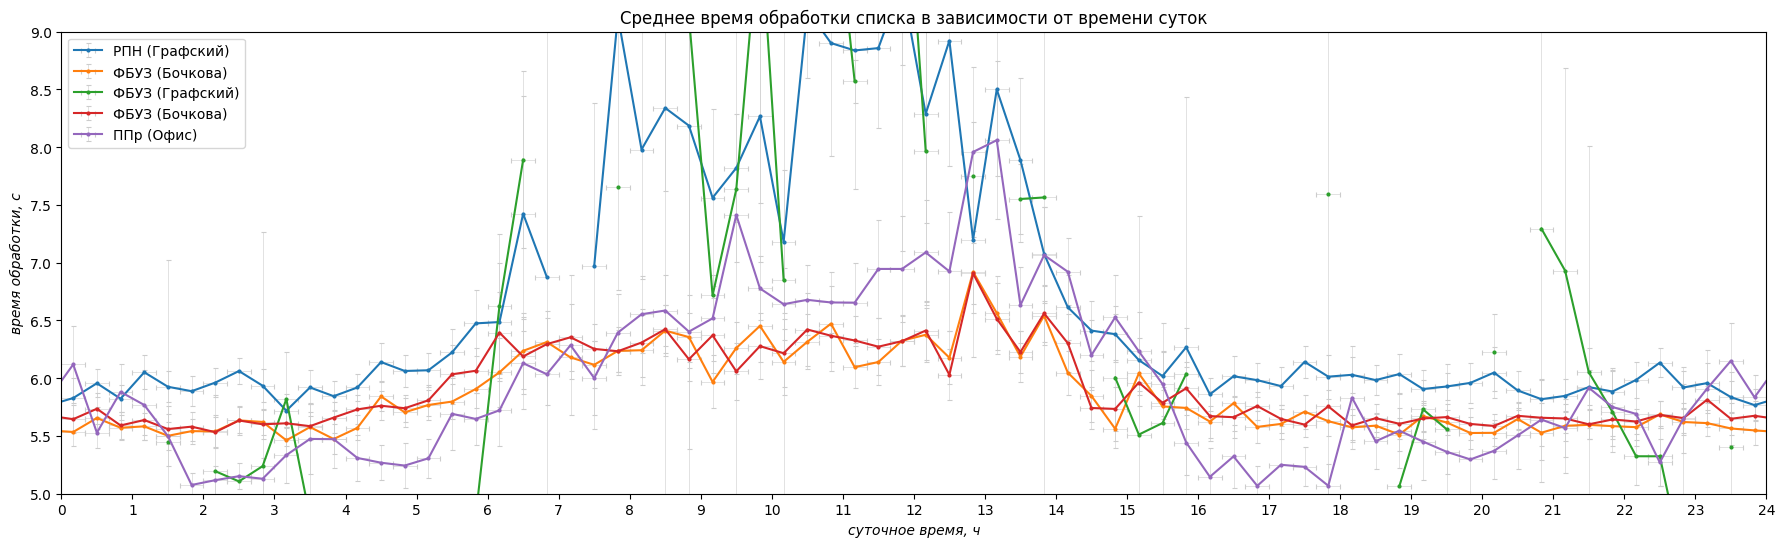

In [ ]:
plt.rcParams["figure.figsize"] = (22,6)

i = 0
while i < len(dfi):
  plt.errorbar(a, abx[i], xerr=da, yerr=ab1[i], ecolor='#cccccc', marker='.', markersize=4, elinewidth=0.4, capsize=1.8, capthick=0.8)
  i = i + 1

plt.xlim([0, 24])
#plt.ylim([11,17])
plt.ylim([5,9])
#plt.ylim([0,0.02])
#plt.ylim([0,0.02])
plt.xticks(range(25))
plt.title('Среднее время обработки списка в зависимости от времени суток')     # itemida
#plt.title('Среднее время обработки карточек в зависимости от времени суток')   # itemidc
#plt.title('Среднее время пинга aisprto.mos.ru в зависимости от времени суток') # itemidp1
#plt.title('Среднее время пинга ya.ru в зависимости от времени суток')          # itemidp2
plt.ylabel('время обработки, c', style='italic')
plt.xlabel('суточное время, ч', style='italic')
plt.legend(['РПН (Графский)', 'ФБУЗ (Бочкова)', 'ФБУЗ (Графский)', 'ФБУЗ (Бочкова)', 'ППр (Офис)'])
#plt.axvline(x=9, color='red', linestyle='dashed', linewidth=2)
#plt.axvline(x=18, color='red', linestyle='dashed', linewidth=2)

Кроме того, можно указать времена и рабочии места для которых была обраружена высокая статистическая вероятность различимости во времени обработки соответсвующих групп мониторинга между рабочими местами, расположенными в исследуемой сети и опорным компьютером, рассположенным вне её. Для определения этой вероятности между распределениями используем z-тест.

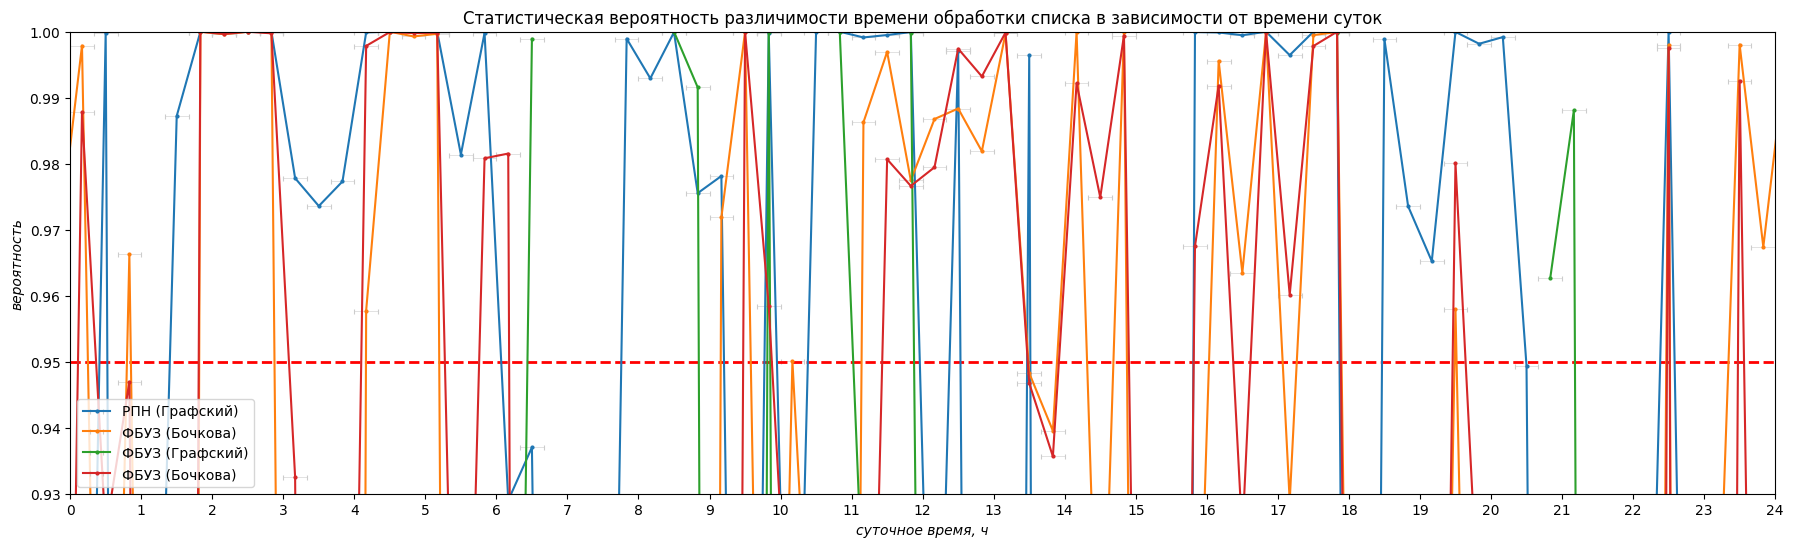

In [ ]:
plt.rcParams["figure.figsize"] = (22,6)

i = 0
while i < (len(att) - 1):
  plt.errorbar(a, att[i], xerr=da, ecolor='#cccccc', marker='.', markersize=4, elinewidth=0.4, capsize=1.8, capthick=0.8) #, linestyle='None')
  i = i + 1

plt.xlim([0, 24])
plt.ylim([0.93, 1])
plt.xticks(range(25))
plt.title('Статистическая вероятность различимости времени обработки списка в зависимости от времени суток')
#plt.title('Статистическая вероятность различимости обработки карточек в зависимости от времени суток')
#plt.title('Статистическая вероятность различимости пинга aisprto.mos.ru в зависимости от времени суток')
#plt.title('Статистическая вероятность различимости пинга ya.ru в зависимости от времени суток')
plt.ylabel('вероятность', style='italic')
plt.xlabel('суточное время, ч', style='italic')
plt.legend(['РПН (Графский)', 'ФБУЗ (Бочкова)', 'ФБУЗ (Графский)', 'ФБУЗ (Бочкова)'])
plt.axhline(1 - pvalue, color='red', linestyle='dashed', linewidth=2)
#plt.axvline(x=9, color='red', linestyle='dashed', linewidth=2)
#plt.axvline(x=18, color='red', linestyle='dashed', linewidth=2)

В случае необходимости выразить данные только лишь некоторыми числами можно использовать соответсвующие статистики.

In [ ]:
dfi[-1].loc[(df_ld['itemid'] == itemida[-1]), 'value'].describe()

count    4373.000000
mean       13.390611
std         2.413345
min         8.437661
25%        11.726614
50%        12.692437
75%        14.368011
max        26.689703
Name: value, dtype: float64

## Вывод

Мониторинг производился круглосуточно с 27.03.24 по 04.04.24.
При этом станции мониторинга были размещены в пяти сегментах различных СПД:
1.	Две станции в сегменте СПД ФБУЗ/РПН (Графский), который имел оконечную связность с КМС посредством прокси–сервера, на котором были включены проксирование и фильтрация трафика.
2.	Одна станция в сегменте СПД ФБУЗ/РПН (Графский), который имел оконечную связность с КМС напрямую (без прокси–сервера).
3.	Одна станция в сегменте СПД ФБУЗ/РПН (Бочкова), который имел оконечную связность с КМС напрямую (без прокси–сервера).
4.	Одна станция в сегменте СПД ФБУЗ/РПН (Графский), который имел оконечную связность с КМС напрямую (без прокси–сервера).

Анализ графиков на показывает зависимость времени исполнения действий от времени рабочего дня: в рабочее время, из-за нагрузки на СПД увеличиваются времена отработки.

Анализ трафика по открытию карточек заявлений, говорит о том, что в сегменте (1), в котором настроено проксирование и фильтрация трафика, значения показателей открытия карточки и списка существенно выше, чем в (3) и (4). При этом, в моменте мы можем наблюдать «выпавшие» значения – таймаут отработки скриптов открытия карточек и реестра. Это говорит о необходимости корректной настройки проксирования и фильтрации для ускорения исполнения действий открытия карточек и списка до значений сегмента (3).

Графики доступности серверов ya.ru, говорят о боле-менее оптимальных скоростях исполнения действия во всех сегментах, за исключением сегмента – СПД ППр. (Сеть ППр – достаточно сложный объект, оптимизация которого выходит за рамки рассмотрения)

Графики доступности серверов aisprto.mos.ru, говорят о более высоких скоростях исполнения действия в сегменте (1), по сравнению с сегментом (3). Такие результаты можно объяснить более оптимальной маршрутизацией трафика в сегменте (1).

В сегменте – СПД ППр. (Сеть ППр – достаточно сложный объект, оптимизация которого выходит за рамки рассмотрения) наблюдаются более высокие времена пингов исследуемых систем.

Исходя из проведенных измерений, рекомендуется ускорить времена исполнения действий открытия карточек и списков для рабочих станций ФБУЗ и РПН, размещенных в сегменте (1), за счет отказа/более оптимальных проксирования и фильтрации трафика.
